 ### 📝 **Python Notes:**
 - `np.zeros((H*W*3))` : This uses a tuple to define the shape. This is the ecommended way because tuples are immutable
 - `np.zeros([H*W*3])` :  This uses a list to define the shape. This will work as ell but is not the recommneded way.
 - `np.arange(W)` : Returns a numpy array generating values from 0 to W-1
 - `u,v = np.meshgrid(u,v)` :  If u and v are 1-D vectors with length U and V espectively, this operation returns 2, 2-D vectors of shape (V,U). The new ombination of u,v now represents a 2D grid.


    ```python
    u = np.array([1,2,3])
    v = np.array([4,5])

    u,v = np.meshgrid(u,v)

    # u gets repeated for every row
    # u : [[1,2,3],
    #      [1,2,3]]
    #
    # v gets repeated for every column
    # v: [[4,4,4],
    #     [5,5,5]]


    ```

- `np.linalg.norm(dirs, axis = -1, keepdims=True)`: Normalization function from the linear algebra library. dirs is the input, calculates the mag (sqrt) of the vector along the specified axis, z in this case which is the x,y,z component of each direction vector. keepdims=True makes it so that the result of this operation is still a 3D vector with size 1 in the 3rd dimension (H,W,1). This enables using it to divide a 3D vector. Without it, the result would be a 2D vector (H,W).
- `rays_dir.reshape(-1,3)` : This reshapes the 3D vector from (H,W,3) to 2D vector of shape (H*W,3). 
- `x[:,0]` : This is a way to slice a 2D vector. The colon in the first place means, take all the rows and 0 means take only column 0.
- `torch.linspace(start,end,steps)` : Generates a 1D tensor of evenly spaced values between a specified start and end over a given number of steps.
- `unsqueeze` :  Adds an additional dimention at the specified axis. Can also use `reshape` but unsqueeze is preferred for adding dimension because you don't need to explicitly calculate all the dimension lengths.

    ```python
    x = torch.tensor([1, 2, 3])  # Shape: (3,)

    # Add a new dimension at position 0
    x_unsqueezed = x.unsqueeze(0)  # Shape: (1, 3)

    # Add a new dimension at position 1
    x_unsqueezed_1 = x.unsqueeze(1)  # Shape: (3, 1)
    ```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### **Step 1:** Define the properties of the target image to be rendered

- H - Height of the image
- W - Width of the image
- F - Distance between the camera origin and image plane

In [2]:
H = 300   
W = 400   
F = 1200 

### **Step 2:** Setup the ray origin and directions
- Assume one ray per pixel of the image going through the center of the pixel
- `u,v` coordinate system used for the image where u goes along the width from left to right and v goes along the height from top to bottom. Top left is the origin.
- Camera is assumed to be at the center of the image, F units away
- Even though origin of all the rays is the same, a vector is created so that ray point calculations are easier and all use the same shape
- `dirs` are calculated assuming camera as the origin with y axis pointing upward and z axis pointing out of the  screen. They are just the subtraction for the point on the image plane and the origin. They are NOT unit vectors.
- `dirs` are then normalized and reshaped back to 2D vectors. It is common in raytracing operations to flatten all the pixels in a vector.

In [3]:
rays_origin = np.zeros((H*W, 3))
rays_dir = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u,v = np.meshgrid(u,v) # shape (H,W)

dirs = np.stack(
    (
        u - W / 2,
        - (v - H / 2),
        - np.ones_like(u) * F
    ),
    axis=-1
) # shape (H,W,3)

rays_dir = dirs/np.linalg.norm(dirs, axis = -1, keepdims=True) #shape (H,W,3)
rays_dir = rays_dir.reshape(-1,3) #shape (H*W,3)

### Step 3: Define the Sphere object
- `intersect` function takes in a point instead of a ray (typical) because we are calculating intersections with multiple points along every ray and then aggregating the results from them. This is the basis for volumetric rendering.
- Condition for intersection with a sphere is 

    $(x- x_c)^2 + (y-y_c)^2 + (z-z_c)^2 <= r^2 $

In [4]:
class Sphere:
    def __init__(self, center, radius, color):
        self.center = center
        self.radius = radius
        self.color = color

    # points is expected to be of shape (num_points, 3)
    def intersect(self, points):

        condition = ( points[:,0] - self.center[0] )**2 + \
            ( points[:,1] - self.center[1] )**2 + \
            ( points[:,2] - self.center[2] )**2  <=  self.radius**2
        
        num_points = points.shape[0]
        colors = torch.zeros((num_points,3)) # RGB
        densities = torch.zeros((num_points,1))

        colors[condition] = self.color
        densities[condition] = 10

        return colors, densities


### Step 4 : Create the rendering function
- Along each ray there will be a number of points selected where we will do the intersection test, calculate the density and color and aggregate them for the final color of that ray.
- **Accumulated transmittance** is the probability that the ray reaches a particular point without hitting any other particle. So, if there are 2 walls, one behind the other, the wall at the back should not contribute to the color of the ray.
    As per the paper:

    $\alpha_i = 1 - exp(X_i)  where X_i = \sigma_i * \delta_i$
    
    We are passing this value to the compute method: 

    $1 - \alpha_i = exp(X_i)$

    So our input looks something like this

    |    0     |    1     |    2     |    3     |
    |----------|----------|----------|----------|
    | exp(X_0) | exp(X_3) | exp(X_2) | exp(X_3) |
    

    $T_i = exp(\sum_{j=1}^{i-1}X_j)$

    So, 
    $T_2 = exp(X_1)$

    $T_3 = exp(X_1 + X_2)$

    $T_4 = exp(X_1 + X_2 + X_3)$ ...

    This can also be written as:

    $T_3 = exp(X_1) * exp(X_2)$

    $T_4 = exp(X_1) * exp(X_2) * exp(X_3)$ ...

    which is essentially the cumulative product
- **Rendering equation**: The final color of a ray, in a simplistic way is a product of the accumulated transmittance, color, and the alpha blending of a point, summed over all the points over the ray.


In [5]:
def compute_accumulated_transmittance(input):
    # input is of shape (num_rays, num_bins)
    # output is of shape (num_rays, num_bins)
    
    accumulated_transmittance = torch.cumprod(input, dim=1)
    accumulated_transmittance[:,0] = 1
    return accumulated_transmittance

# tn, tf - near and far plane
# num_bins - number of discrete bins the summation is done over
def render(model, rays_origin, rays_dir, tn, tf, num_bins=100, device = 'cpu'):
    
    # Discrete points along each ray
    t = torch.linspace(tn, tf, num_bins).to(device)

    # Delta is same for all points except the last one which is a large value
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))

    # We need a points vector of shape (num_rays, num_bins, 3)
    # rays_origin and rays_dir is of shape (num_rays, 3)
    # t is of shape (num_bins,)
    
    points = rays_origin.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_dir.unsqueeze(1) 

    colors, densities = model.intersect(points.reshape(-1,3))

    # Reshape to (num_rays, num_bins, 3)
    colors = colors.reshape(points.shape[0], num_bins, 3)
    densities = densities.reshape(points.shape[0], num_bins)

    alpha = 1 - torch.exp(- densities * delta.unsqueeze(0))

    T = compute_accumulated_transmittance(1 - alpha)

    final_color = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [numrays, 3]

    return final_color

In [6]:
sphere_position = torch.tensor([0, 0, -1])
sphere_radius = 0.1
sphere_color = torch.tensor([1., 0., 0.])

model = Sphere(sphere_position, sphere_radius, sphere_color)

near_plane = 0.8
far_plane = 1.2
target_image = render(model, torch.tensor(rays_origin), torch.tensor(rays_dir), near_plane, far_plane)

### Step 5: Optimize a color to generate the target image starting from a blank image

**Tensor optimization loop**
- Declare a tensor T with `required_grad=True`. This enables the tensor to record all the operations on the tensor in a computational graph, enabling automatic differentiation. We can then compute the gradient of a loss function Loss(T) derived from T wrt T using the `backward()` funtion on Loss(T).
- The gradient will be stored in the `grad` attribute of T after backpropagation.
- Loss is calculated by squaring the the different in predicated and target image to avoid negative loss values and penalize high error values. Additionally, squared loss function is smooth and differentiable for gradient descent.
- `optimizer.step()` : When this function is called on an optimizer, it automatically takes the input parameters (only T in this case) and performs gradient descent on it based on it's gradients which is basically `T.data = T.data - T.grad`
- `optimizer.zero_grad()`: It resets all the gradient values stored in the `.grad` attribute of all parameters managed by that optimizer to zero. Gradients in PyTorch accumulate by default. This means that if you don't reset them, each new `.backward()` call will add its gradients to whatever is already stored.

### Concrete Optimization Example with SGD

**Problem Definition:**
Start with a black color represented as RGB [0, 0, 0]
Reach a target green color represented as RGB [0, 1, 0]
Use gradient descent with SGD optimizer to update our color values.

```python
import torch

current_color = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)
target_color = torch.tensor([0.0, 1.0, 0.0])

optimizer = torch.optim.SGD([current_color], lr=0.02)

def loss_fn(current, target):
    return ((current - target) ** 2).mean()
```

**Computation Graph for Color Optimization**

Let's look at what happens in the computational graph for a single step:

Forward pass:

Calculate difference: `diff = current_color - target_color = [0, -1, 0]`  
Square differences: `diff_squared = diff ** 2 = [0, 1, 0]`  
Calculate mean: `loss = diff_squared.mean() = 0.333` (mean across the 3 RGB values)  


Backward pass (when loss.backward() is called):

`∂loss/∂loss = 1` (starting point for backpropagation)  
`∂loss/∂diff_squared = [1/3, 1/3, 1/3]` (derivative of mean operation)  
`∂diff_squared/∂diff = [0, -2, 0]` (derivative of square operation applied to [0, -1, 0])  
`∂diff/∂current_color = [1, 1, 1]` (derivative of subtraction)  
Final gradient: `∂loss/∂current_color = [0, -2/3, 0]`  


In practice, PyTorch calculates this automatically when we call `loss.backward()`.  


```python
# Training loop
num_iterations = 10
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(current_color, target_color)
    loss.backward()
    optimizer.step()
```


**Iteration 0:**

Current color: [0, 0, 0] (black)  
Target color: [0, 1, 0] (green)  
Forward Pass:  

Difference: [0-0, 0-1, 0-0] = [0, -1, 0]  
Squared difference: [0, 1, 0]  
Loss: (0 + 1 + 0)/3 = 0.333  


Backward Pass:  

Gradient of loss w.r.t. squared difference: [1/3, 1/3, 1/3]  
Gradient of squared difference w.r.t. difference:  

For red channel: 2 * 0 = 0  
For green channel: 2 * (-1) = -2  
For blue channel: 2 * 0 = 0  


Final gradient: [0 * 1/3, -2 * 1/3, 0 * 1/3] = [0, -0.667, 0]  


Update using SGD (learning rate = 0.02):  
  
New red: 0 - 0.02 * 0 = 0  
New green: 0 - 0.02 * (-0.667) = 0.0133  
New blue: 0 - 0.02 * 0 = 0  
New color: [0, 0.0133, 0]  

This process will continue for each iteration of the training loop.

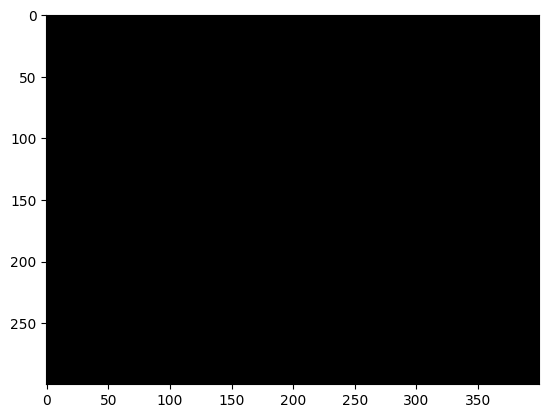

Epoch 0, Loss: 0.0607115775346756, Color: [0.01214231 0.         0.        ]


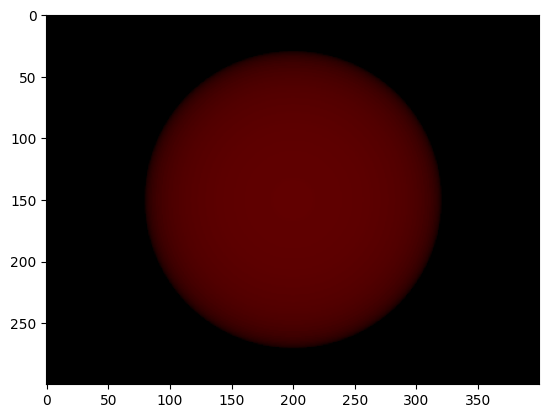

Epoch 50, Loss: 0.017894091084599495, Color: [0.46369305 0.         0.        ]


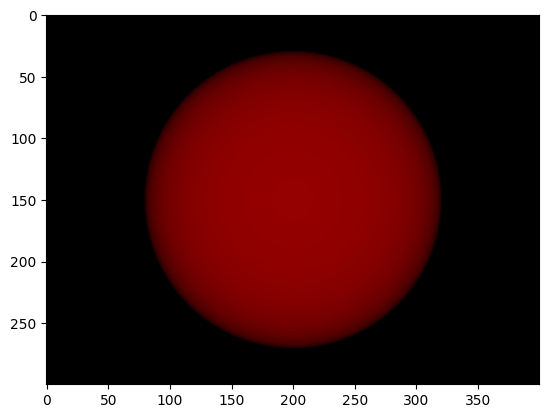

Epoch 100, Loss: 0.0052740853279829025, Color: [0.7088397 0.        0.       ]


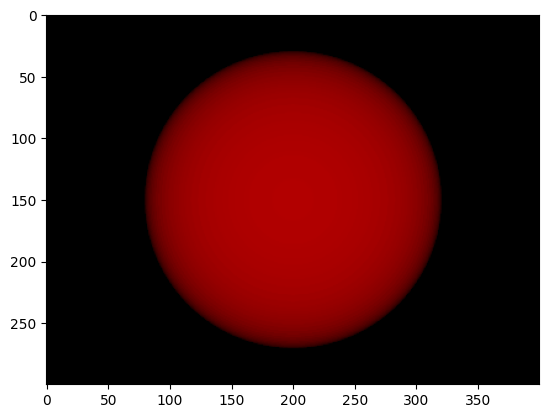

Epoch 150, Loss: 0.0015544799389317632, Color: [0.8419294 0.        0.       ]


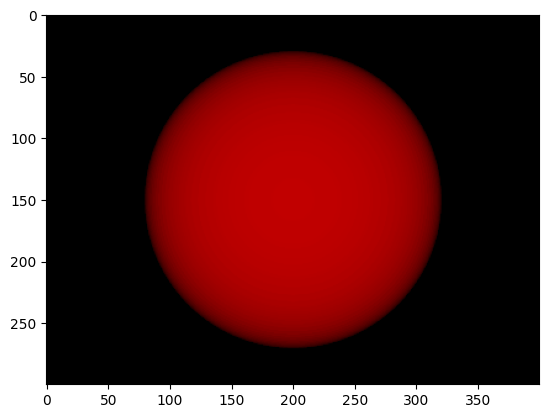

Epoch 200, Loss: 0.0004581663233693689, Color: [0.9141836 0.        0.       ]


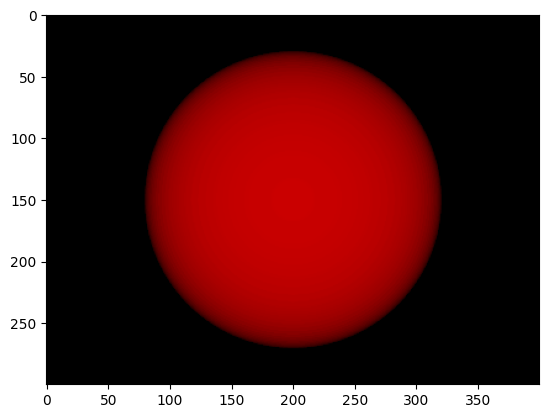

Epoch 250, Loss: 0.00013503932859748602, Color: [0.95341045 0.         0.        ]


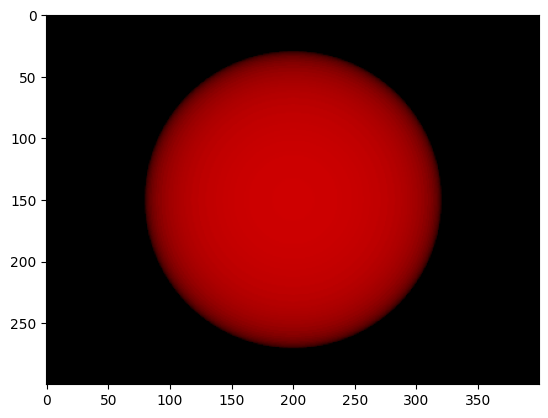

Epoch 300, Loss: 3.980117617174983e-05, Color: [0.97470665 0.         0.        ]


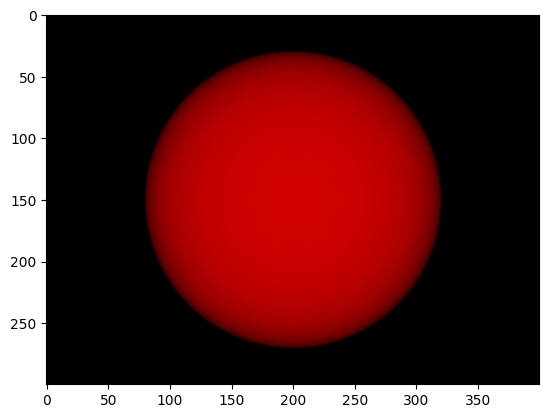

Epoch 350, Loss: 1.173103282781085e-05, Color: [0.9862682 0.        0.       ]


In [7]:
color_to_optimize = torch.tensor([0., 0., 0.], requires_grad=True)
optimizer = torch.optim.SGD({color_to_optimize},lr=1e-1)

for epoch in range(400):

    model = Sphere(sphere_position, sphere_radius, color_to_optimize)
    
    predicted_image = render(model, torch.tensor(rays_origin), torch.tensor(rays_dir), near_plane, far_plane)

    loss = ((predicted_image - target_image)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        img = predicted_image.reshape(H, W, 3).cpu().data.numpy()
        plt.imshow(img)
        plt.show()
        print(f"Epoch {epoch}, Loss: {loss.item()}, Color: {color_to_optimize.data.numpy()}")